<a href="https://colab.research.google.com/github/leonsuarez24/Notebooks/blob/main/E2E_SPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
!pip install torchinfo
from torchinfo import summary

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset.data = transforms.Resize((32,32))(trainset.data)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testset.data = transforms.Resize((32,32))(testset.data)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:01<00:00, 15833514.59it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265845.94it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5029648.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19736999.08it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



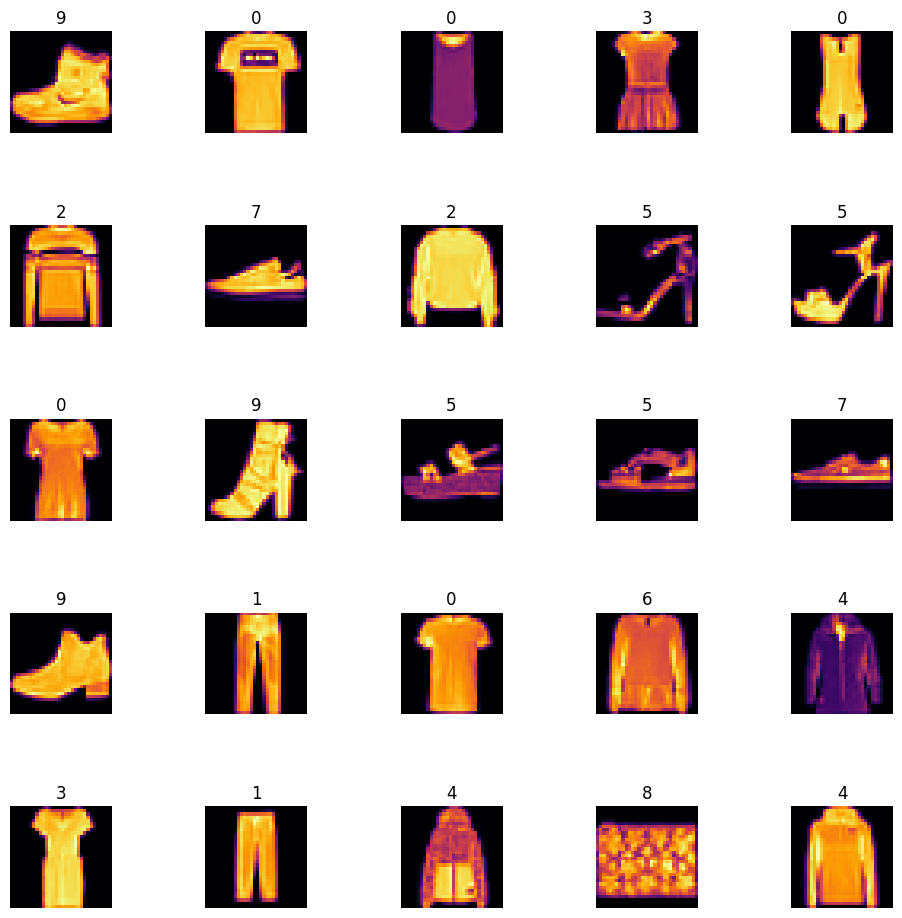

torch.Size([32, 32])


In [ ]:
fig, ax = plt.subplots(5, 5)
fig.tight_layout()
fig.set_size_inches(10,10)
k = 0
for i in range(5):
  for j in range(5):
    ax[i, j].imshow(trainset.data[k], cmap='inferno')
    ax[i, j].set_title(f"{trainset.targets[k]}")
    ax[i, j].axis('off')
    k +=1

plt.show()
print(trainset.data[0].shape)

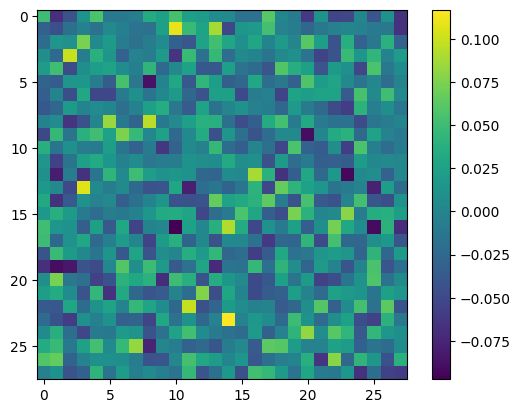

tensor(0.0350) tensor(-3.3425e-05)


In [ ]:
ca = (torch.normal(0, 1, (10, 28, 28))/ np.sqrt(28*28))
plt.imshow(ca[0,:,:])
plt.colorbar()
plt.show()
print(torch.std(ca[0]), torch.mean(ca[0]))

In [ ]:
class OpticalLayer(nn.Module):
    def __init__(self, K, output_dim, input_dim):
        super(OpticalLayer, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.K = K
        ca = torch.normal(0, 1, (self.K, self.output_dim, self.input_dim))
        self.weights = nn.Parameter(ca / np.sqrt(self.output_dim * self.input_dim))
        #torch.nn.init.normal_(self.weights, mean=0.0, std=0.04)

    def forward(self, x):
        # Downscale to 1 px
        ca_w = torch.unsqueeze(self.weights, 0)
        x = torch.mul(x, ca_w)
        x = torch.sum(x, dim=(-2, -1))
        x = torch.unsqueeze(x, -1)
        x = torch.unsqueeze(x, -1)
        # Upscale to 28x28
        x = torch.mul(x, ca_w)
        x = torch.sum(x, dim=1)
        x = torch.unsqueeze(x, 1)
        x = x / torch.max(x)
        return x

In [ ]:
ol = OpticalLayer(160,32,32).to(device)
summary(ol, input_size=(321, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
OpticalLayer                             [321, 1, 32, 32]          163,840
Total params: 163,840
Trainable params: 163,840
Non-trainable params: 0
Total mult-adds (M): 52.59
Input size (MB): 1.31
Forward/backward pass size (MB): 2.63
Params size (MB): 0.66
Estimated Total Size (MB): 4.60

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()

        # Encoder
        self.e11 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Input: 1x32x32, Output: 16x32x32
        self.e12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)  # Output: 16x32x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16x16

        self.e21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: 32x16x16
        self.e22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Output: 32x16x16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x8x8

        self.e31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x8x8
        self.e32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Output: 64x8x8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x4x4

        self.e41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128x4x4
        self.e42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: 128x4x4
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x2x2

        self.e51 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: 256x2x2
        self.e52 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output: 256x2x2


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x4x4
        self.d11 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x8x8
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x16x16
        self.d31 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # Output: 16x32x32
        self.d41 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(16, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder
        xu1 = F.relu(self.upconv1(xe52))
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = F.relu(self.upconv2(xd12))
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = F.relu(self.upconv3(xd22))
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = F.relu(self.upconv4(xd32))
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
unet = UNet(1)
print(summary(unet, input_size=(12, 1, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [12, 1, 32, 32]           --
├─Conv2d: 1-1                            [12, 16, 32, 32]          160
├─Conv2d: 1-2                            [12, 16, 32, 32]          2,320
├─MaxPool2d: 1-3                         [12, 16, 16, 16]          --
├─Conv2d: 1-4                            [12, 32, 16, 16]          4,640
├─Conv2d: 1-5                            [12, 32, 16, 16]          9,248
├─MaxPool2d: 1-6                         [12, 32, 8, 8]            --
├─Conv2d: 1-7                            [12, 64, 8, 8]            18,496
├─Conv2d: 1-8                            [12, 64, 8, 8]            36,928
├─MaxPool2d: 1-9                         [12, 64, 4, 4]            --
├─Conv2d: 1-10                           [12, 128, 4, 4]           73,856
├─Conv2d: 1-11                           [12, 128, 4, 4]           147,584
├─MaxPool2d: 1-12                        [12, 128, 2, 2]  

In [ ]:
class E2E(nn.Module):
  def __init__(self, K, output_dim, input_dim, n_class):
    super(E2E, self).__init__()
    self.optical_layer = OpticalLayer(K, output_dim, input_dim)
    self.UNET = UNet(n_class)

  def forward(self, x):
    out = self.optical_layer(x)
    out = self.UNET(out)
    return out

In [ ]:
e2e = E2E(160, 32, 32, 1)
print(summary(e2e, input_size=(12, 1, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
E2E                                      [12, 1, 32, 32]           --
├─OpticalLayer: 1-1                      [12, 1, 32, 32]           163,840
├─UNet: 1-2                              [12, 1, 32, 32]           --
│    └─Conv2d: 2-1                       [12, 16, 32, 32]          160
│    └─Conv2d: 2-2                       [12, 16, 32, 32]          2,320
│    └─MaxPool2d: 2-3                    [12, 16, 16, 16]          --
│    └─Conv2d: 2-4                       [12, 32, 16, 16]          4,640
│    └─Conv2d: 2-5                       [12, 32, 16, 16]          9,248
│    └─MaxPool2d: 2-6                    [12, 32, 8, 8]            --
│    └─Conv2d: 2-7                       [12, 64, 8, 8]            18,496
│    └─Conv2d: 2-8                       [12, 64, 8, 8]            36,928
│    └─MaxPool2d: 2-9                    [12, 64, 4, 4]            --
│    └─Conv2d: 2-10                      [12, 128, 4, 4]      

In [ ]:
optimizer = torch.optim.Adam(e2e.parameters())
criterion = torch.nn.MSELoss()
epochs = 10
regularizer_parameter = 1e-3

for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    optimizer.zero_grad()

    pred = e2e(inputs)
    loss = criterion(pred, inputs) + regularizer_parameter * (torch.sum(torch.mul(torch.pow(1 + e2e.optical_layer.weights, 2), torch.pow(1 - e2e.optical_layer.weights, 2))))

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if (i + 1) % 375 == 0:  # Print the running loss every 375 mini-batches
      print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 375:.3f}')
      running_loss = 0.0

print('Training finished!')

Epoch: 1, Batch: 375, Loss: 153.379
Epoch: 1, Batch: 750, Loss: 65.950
Epoch: 1, Batch: 1125, Loss: 6.261
Epoch: 1, Batch: 1500, Loss: 1.194
Epoch: 1, Batch: 1875, Loss: 0.659
Epoch: 2, Batch: 375, Loss: 0.404
Epoch: 2, Batch: 750, Loss: 0.265
Epoch: 2, Batch: 1125, Loss: 0.191
Epoch: 2, Batch: 1500, Loss: 0.152
Epoch: 2, Batch: 1875, Loss: 0.123
Epoch: 3, Batch: 375, Loss: 0.097
Epoch: 3, Batch: 750, Loss: 0.076
Epoch: 3, Batch: 1125, Loss: 0.059
Epoch: 3, Batch: 1500, Loss: 0.045
Epoch: 3, Batch: 1875, Loss: 0.034
Epoch: 4, Batch: 375, Loss: 0.027
Epoch: 4, Batch: 750, Loss: 0.023
Epoch: 4, Batch: 1125, Loss: 0.021
Epoch: 4, Batch: 1500, Loss: 0.021
Epoch: 4, Batch: 1875, Loss: 0.020
Epoch: 5, Batch: 375, Loss: 0.020
Epoch: 5, Batch: 750, Loss: 0.020
Epoch: 5, Batch: 1125, Loss: 0.020
Epoch: 5, Batch: 1500, Loss: 0.020
Epoch: 5, Batch: 1875, Loss: 0.019
Epoch: 6, Batch: 375, Loss: 0.019
Epoch: 6, Batch: 750, Loss: 0.019
Epoch: 6, Batch: 1125, Loss: 0.019
Epoch: 6, Batch: 1500, Loss: 

In [ ]:
e2e.optical_layer.weights.shape

torch.Size([160, 32, 32])

In [ ]:
def plot_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(len(images)):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'CA: {i + 1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

torch.Size([160, 32, 32])


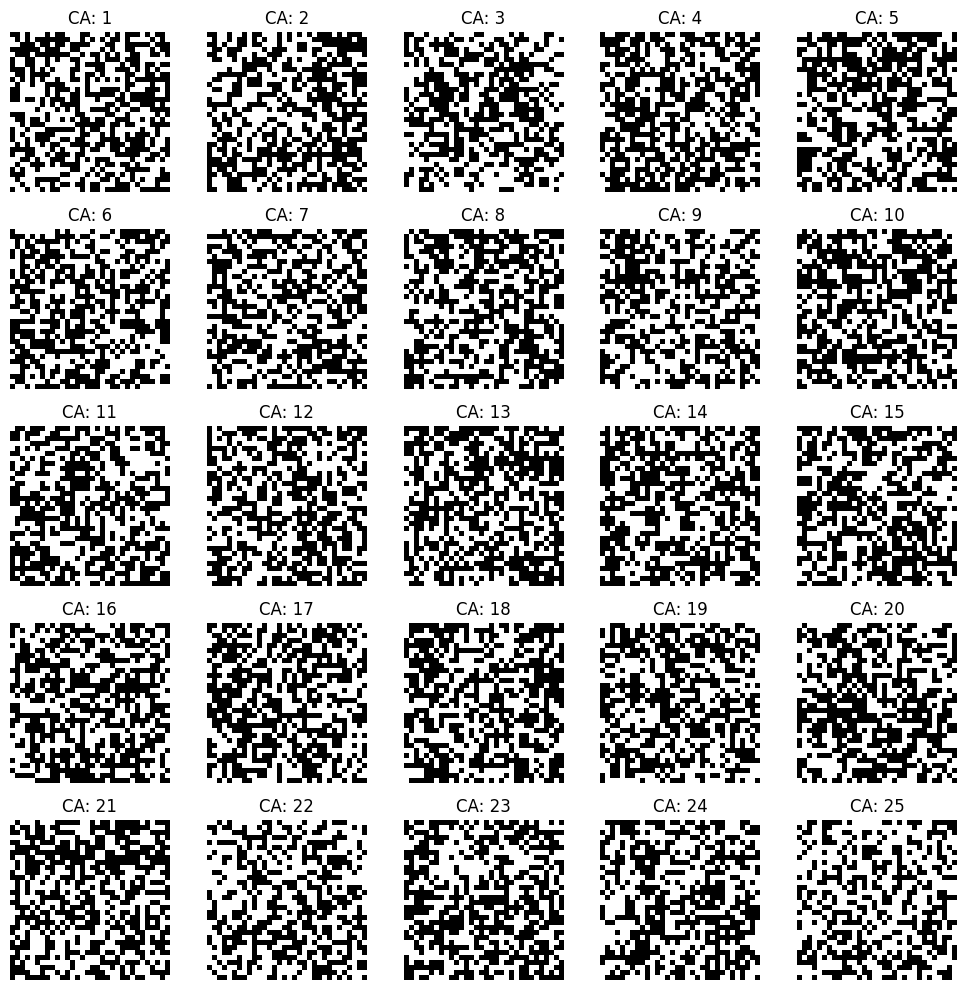

In [ ]:
subset_indices = torch.randint(0, len(testset), (25,))
subset_images = [testset[i][0] for i in subset_indices]
subset_labels = [testset[i][1] for i in subset_indices]
subset_images = torch.stack(subset_images).to(device)
e2e.eval()
spc = e2e.cpu()
subset_images = subset_images.cpu()

with torch.no_grad():
    outputs = spc(subset_images)
    _, predicted = torch.max(outputs, 1)
    print(e2e.optical_layer.weights.shape)
    plot_images(e2e.optical_layer.weights[:25,:,:])

In [ ]:
# Evaluation
reconstruced_imgs=[]
with torch.no_grad():
  for data in testloader:
    images, _ = data
    images = images.to("cpu")
    reconstruced_imgs.append(torch.squeeze(e2e(images), dim = 1))

In [ ]:
print(reconstruced_imgs[0].shape)

torch.Size([32, 32, 32])


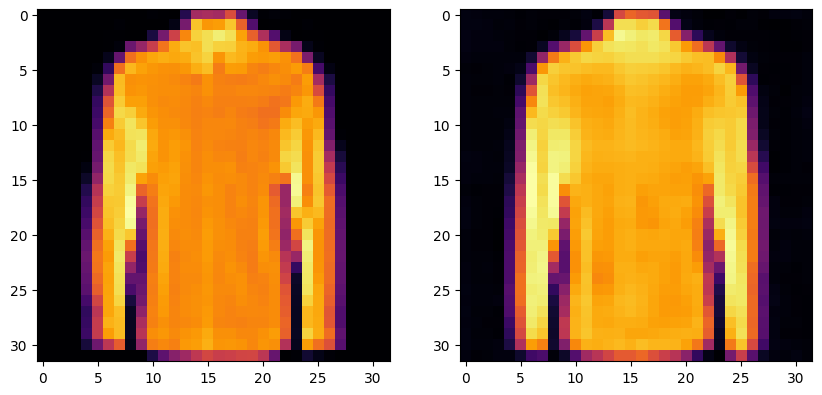

In [ ]:
index = 9000
batch = index//32
f, ax = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(10)
ax[0].imshow(testset.data[index],cmap='inferno')
ax[1].imshow(torch.squeeze(reconstruced_imgs[batch][index - batch*32]),cmap='inferno')
plt.show()

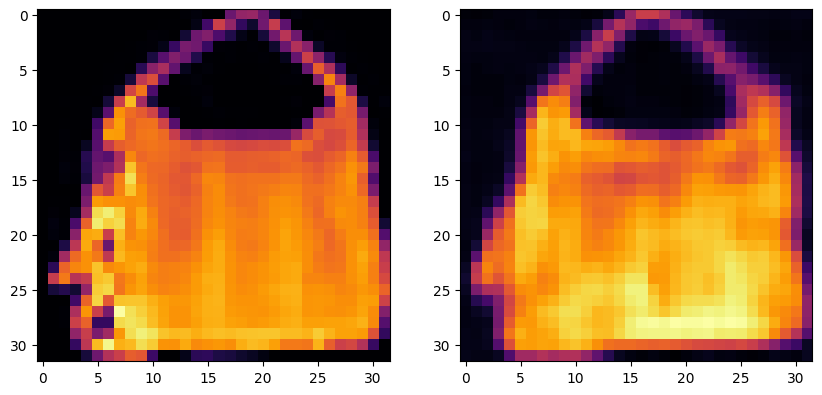

In [ ]:
index = 9500
batch = index//32
f, ax = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(10)
ax[0].imshow(testset.data[index],cmap='inferno')
ax[1].imshow(torch.squeeze(reconstruced_imgs[batch][index - batch*32]),cmap='inferno')
plt.show()